In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [11]:
pd.set_option('display.max_columns', None)  # Показать все столбцы
pd.set_option('display.width', 1900)        # Установить ширину области отображения

In [12]:
# Загрузка данных
data = pd.read_csv('processed_train.csv', sep=';') # Обратите внимание на путь файла

# Просмотр первых строк
print(data.head())

   id  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  Tool Wear Failure [TWF]  Heat Dissipation Failure [HDF]  Power Failure [PWF]  Overstrain Failure [OSF]  Random Failure [RNF]  Type_H  Type_L  Type_M
0   0                300.6                    309.6                    1596         36.1              140                0                        0                               0                    0                         0                     0   False    True   False
1   1                302.6                    312.1                    1759         29.1              200                0                        0                               0                    0                         0                     0   False   False    True
2   2                299.3                    308.5                    1802         26.5               25                0                        0                               0  

In [13]:
# Для каждого столбца выводим минимальное и максимальное значение
for column in data.columns:
    # Проверим, является ли столбец числовым (это важно для исключения категориальных данных)
    if data[column].dtype in ['int64', 'float64']:
        min_value = data[column].min()
        max_value = data[column].max()
        print(f"Диапазон для {column}: от {min_value} до {max_value}")

Диапазон для id: от 0 до 136428
Диапазон для Air temperature [K]: от 295.3 до 304.4
Диапазон для Process temperature [K]: от 305.8 до 313.8
Диапазон для Rotational speed [rpm]: от 1210 до 1802
Диапазон для Torque [Nm]: от 17.35 до 63.35
Диапазон для Tool wear [min]: от 0 до 253
Диапазон для Machine failure: от 0 до 1
Диапазон для Tool Wear Failure [TWF]: от 0 до 1
Диапазон для Heat Dissipation Failure [HDF]: от 0 до 1
Диапазон для Power Failure [PWF]: от 0 до 1
Диапазон для Overstrain Failure [OSF]: от 0 до 1
Диапазон для Random Failure [RNF]: от 0 до 1


In [15]:
import pandas as pd

# Чтение данных
data = pd.read_csv('processed_train.csv', sep=';')

# Функция для удаления выбросов с использованием IQR
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    
    # Фильтруем данные, удаляя выбросы
    df_no_outliers = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
    
    return df_no_outliers

# Удаление выбросов для числовых столбцов
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
data_no_outliers = remove_outliers(data[numeric_columns])

# Группировка по целевой переменной 'Machine failure' и вычисление минимальных и максимальных значений
min_max_stats = data_no_outliers.groupby('Machine failure').agg(['min', 'max'])

# Реборка DataFrame в более читаемый вид
min_max_stats = min_max_stats.T  # Транспонируем, чтобы признаки шли по строкам

# Выводим результат в более компактном и читаемом виде
for column in min_max_stats.columns.levels[0]:  # Обрабатываем уровень для 'Machine failure'
    print(f"Признак: {column}")
    print(f"  Machine failure = 0: min = {min_max_stats[column]['min'][0]}, max = {min_max_stats[column]['max'][0]}")
    print(f"  Machine failure = 1: min = {min_max_stats[column]['min'][1]}, max = {min_max_stats[column]['max'][1]}")
    print("-" * 50)


AttributeError: 'Index' object has no attribute 'levels'

In [4]:
# Получение общей информации о данных
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 15 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              136429 non-null  int64  
 1   Air temperature [K]             136429 non-null  float64
 2   Process temperature [K]         136429 non-null  float64
 3   Rotational speed [rpm]          136429 non-null  int64  
 4   Torque [Nm]                     136429 non-null  float64
 5   Tool wear [min]                 136429 non-null  int64  
 6   Machine failure                 136429 non-null  int64  
 7   Tool Wear Failure [TWF]         136429 non-null  int64  
 8   Heat Dissipation Failure [HDF]  136429 non-null  int64  
 9   Power Failure [PWF]             136429 non-null  int64  
 10  Overstrain Failure [OSF]        136429 non-null  int64  
 11  Random Failure [RNF]            136429 non-null  int64  
 12  Type_H          

### Описание столбцов:
- **id**: Идентификатор записи
- **Product ID**: Идентификатор продукта
- **Type**: Тип оборудования (L, M, H)
- **Air temperature [K]**: Температура воздуха (в Кельвинах)
- **Process temperature [K]**: Температура процесса (в Кельвинах)
- **Rotational speed [rpm]**: Скорость вращения (об/мин)
- **Torque [Nm]**: Крутящий момент (Н·м)
- **Tool wear [min]**: Износ инструмента (минуты)
- **Machine failure**: Отказ оборудования *(Целевая переменная)*
- **Tool Wear Failure [TWF]**: Отказ из-за износа инструмента
- **Heat Dissipation Failure [HDF]**: Отказ из-за проблем с охлаждением
- **Power Failure [PWF]**: Отказ из-за проблем с подачей электроэнергии
- **Overstrain Failure [OSF]**: Отказ из-за перенапряжения
- **Random Failure [RNF]**: Случайный отказ


Давайте расчитает сумму значений для параметров отказов. Сохраним в столбец `Sum_Parametr`. Далее можно проанализировать влияние данного параметра на целевую переменную.

In [5]:
data['Sum_Parametr'] = data['Tool Wear Failure [TWF]'] + data['Heat Dissipation Failure [HDF]'] + data['Power Failure [PWF]'] + data['Overstrain Failure [OSF]'] + data['Random Failure [RNF]']
print(data['Sum_Parametr'])

0         0
1         0
2         0
3         0
4         0
         ..
136424    0
136425    0
136426    0
136427    0
136428    0
Name: Sum_Parametr, Length: 136429, dtype: int64


Появился столбец `Sum_Parametr` - сумма бинарных значений столбцов:
-  **Tool Wear Failure [TWF]**   
-  **Heat Dissipation Failure [HDF]**   
-  **Power Failure [PWF]**   
-  **Overstrain Failure [OSF]**   
-  **Random Failure [RNF]**

Использую значени `Sum_Parametr` - посмотрим как он влияет на целевую переменную!

In [6]:
#print(data.info())

In [7]:
print('Среднее Tool Wear Failure [TWF]: ', data['Tool Wear Failure [TWF]'].mean())
print('Среднее THeat Dissipation Failure [HDF]: ', data['Heat Dissipation Failure [HDF]'].mean())
print('Среднее Power Failure [PWF]: ', data['Power Failure [PWF]'].mean())
print('Среднее Overstrain Failure [OSF]: ', data['Overstrain Failure [OSF]'].mean())
print('Среднее Random Failure [RNF]: ', data['Random Failure [RNF]'].mean())

Среднее Tool Wear Failure [TWF]:  0.0015539218201408792
Среднее THeat Dissipation Failure [HDF]:  0.005160193214052731
Среднее Power Failure [PWF]:  0.002396851109368243
Среднее Overstrain Failure [OSF]:  0.003958102749415447
Среднее Random Failure [RNF]:  0.0022575845311480695


In [8]:
print('Сумма всех значений Tool Wear Failure [TWF]: ', data['Tool Wear Failure [TWF]'].sum())
print('Сумма всех значений THeat Dissipation Failure [HDF]: ', data['Heat Dissipation Failure [HDF]'].sum())
print('Сумма всех значений Power Failure [PWF]: ', data['Power Failure [PWF]'].sum())
print('Сумма всех значений Overstrain Failure [OSF]: ', data['Overstrain Failure [OSF]'].sum())
print('Сумма всех значений Random Failure [RNF]: ', data['Random Failure [RNF]'].sum())

print('\nОбщее количество строк: 136428')

Сумма всех значений Tool Wear Failure [TWF]:  212
Сумма всех значений THeat Dissipation Failure [HDF]:  704
Сумма всех значений Power Failure [PWF]:  327
Сумма всех значений Overstrain Failure [OSF]:  540
Сумма всех значений Random Failure [RNF]:  308

Общее количество строк: 136428


### Вывод

Значения **Среднее** и **Сумма** показывают, что в бинарных столбцах не так много **положительных значений (1)**.  

Большая часть значений — **0**, что говорит о том, что один столбец, по отдельности, мало влияет на целевую переменную.


In [9]:
# Группировка по Sum_Parametr и подсчет количества случаев Machine failure = 0 и 1
result = data.groupby('Sum_Parametr')['Machine failure'].value_counts().unstack(fill_value=0)

# Переименуем колонки для удобства чтения
result.columns = ['Не сломается (0)', 'Сломается (1)']

# Рассчитаем долю отказов для каждого значения Sum_Parametr
result['Доля отказов (%)'] = (result['Сломается (1)'] / result.sum(axis=1)) * 100

print(result)

              Не сломается (0)  Сломается (1)  Доля отказов (%)
Sum_Parametr                                                   
0                       133966            507          0.377027
1                          315           1512         82.758621
2                            0            123        100.000000
3                            0              6        100.000000


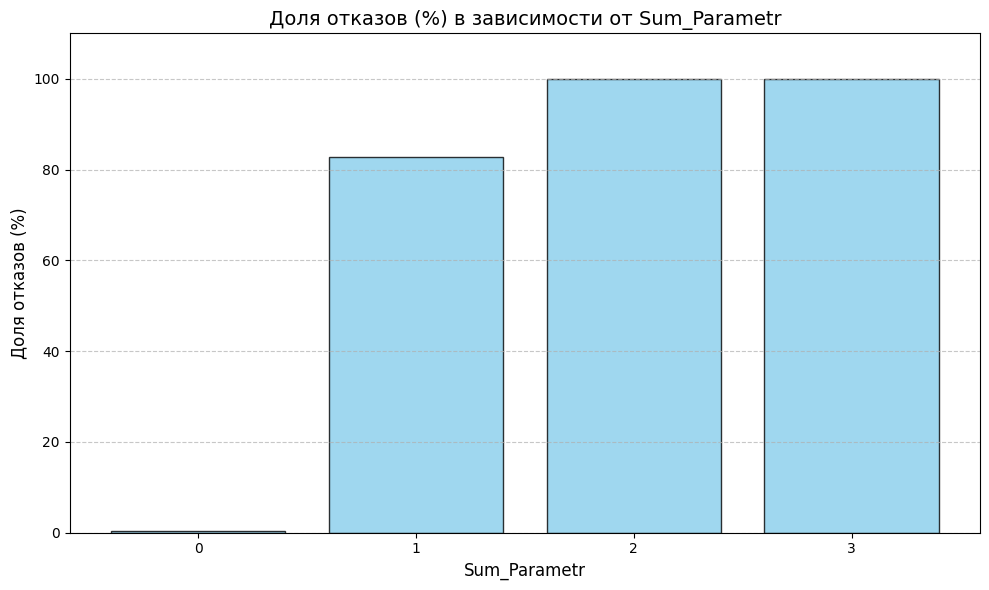

In [10]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.bar(result.index, result['Доля отказов (%)'], color='skyblue', edgecolor='black', alpha=0.8)

# Настройка графика
plt.title('Доля отказов (%) в зависимости от Sum_Parametr', fontsize=14)
plt.xlabel('Sum_Parametr', fontsize=12)
plt.ylabel('Доля отказов (%)', fontsize=12)
plt.xticks(result.index)  # Установка меток оси X
plt.ylim(0, 110)  # Установка диапазона для оси Y
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Показать график
plt.tight_layout()
plt.show()

### Вывод

Суммарный показатель существенно влияет на целевую переменую, давайте узнаю какие именного параметры отказа максмально влияют на работу оборудования.

In [11]:
# Перемещение столбца 'Sum_Parametr' на 12 место - так логичнее
columns = list(data.columns)
columns.insert(12, columns.pop(columns.index('Sum_Parametr')))
data = data[columns]

# Вывод новой структуры
# print(data.info())

In [12]:
# Список столбцов для анализа
failure_columns = [
    'Tool Wear Failure [TWF]',
    'Heat Dissipation Failure [HDF]',
    'Power Failure [PWF]',
    'Overstrain Failure [OSF]',
    'Random Failure [RNF]'
]

# Анализ каждого столбца
for col in failure_columns:
    print(f"\nАнализ столбца: {col}")
    
    # Группировка данных
    result = data.groupby(col)['Machine failure'].value_counts().unstack(fill_value=0)
    
    # Переименуем столбцы для удобства
    result.columns = ['Не сломается (0)', 'Сломается (1)']
    
    # Добавим долю отказов
    result['Доля отказов (%)'] = (result['Сломается (1)'] / result.sum(axis=1)) * 100
    
    # Вывод результата
    print(result)


Анализ столбца: Tool Wear Failure [TWF]
                         Не сломается (0)  Сломается (1)  Доля отказов (%)
Tool Wear Failure [TWF]                                                   
0                                  134281           1936          1.421262
1                                       0            212        100.000000

Анализ столбца: Heat Dissipation Failure [HDF]
                                Не сломается (0)  Сломается (1)  Доля отказов (%)
Heat Dissipation Failure [HDF]                                                   
0                                         134275           1450          1.068337
1                                              6            698         99.147727

Анализ столбца: Power Failure [PWF]
                     Не сломается (0)  Сломается (1)  Доля отказов (%)
Power Failure [PWF]                                                   
0                              134278           1824          1.340171
1                                

В табличном представлении не столь наглядно видно результат влияния, поэтому постриям график для параметра `Процент отказа (%)`

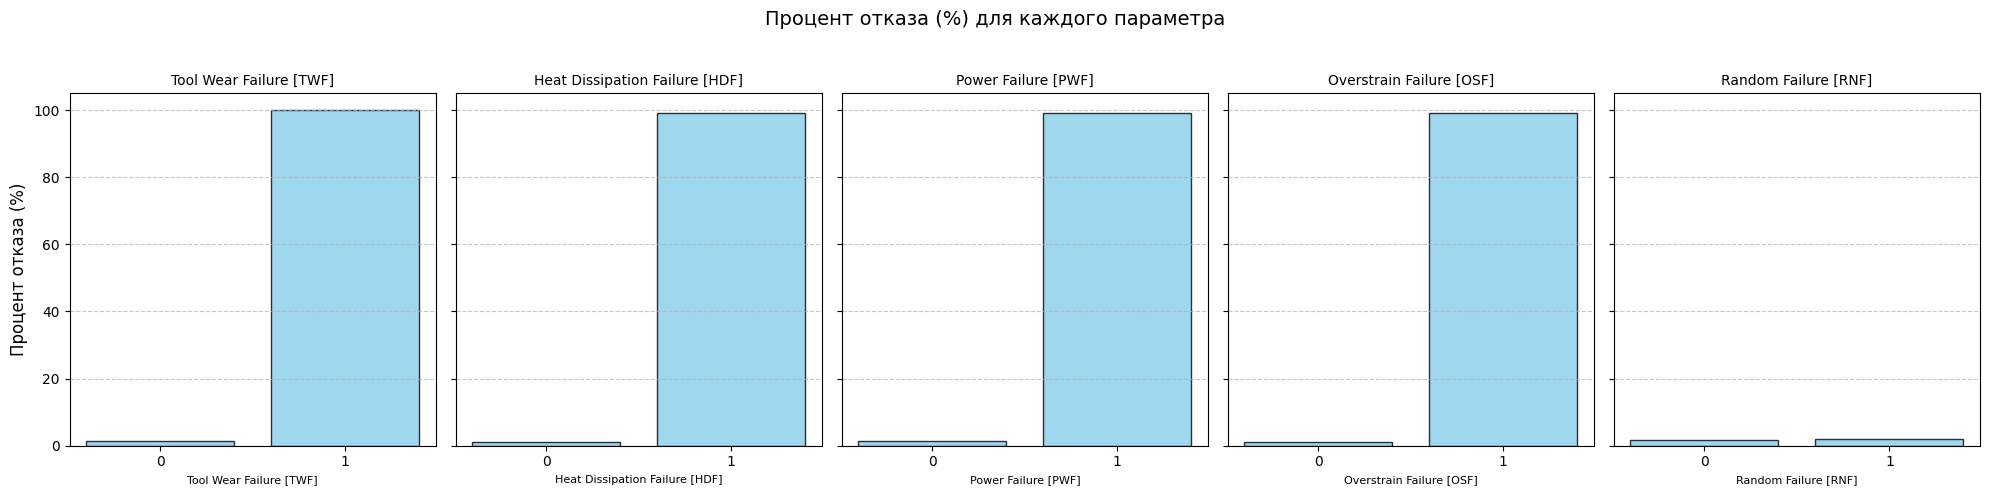

In [13]:
# Создаем фигуру с несколькими подграфиками в одну строку
fig, axes = plt.subplots(1, len(failure_columns), figsize=(20, 5), sharey=True)

# Анализ и визуализация для каждого столбца
for ax, col in zip(axes, failure_columns):
    # print(f"\nАнализ столбца: {col}")
    
    # Группировка данных
    result = data.groupby(col)['Machine failure'].value_counts().unstack(fill_value=0)
    
    # Переименуем столбцы для удобства
    result.columns = ['Не сломается (0)', 'Сломается (1)']
    
    # Добавим долю отказов (по-английски)
    result['Процент отказа (%)'] = (result['Сломается (1)'] / result.sum(axis=1)) * 100
    
    # Вывод результата в консоль
    # print(result)
    
    # Построение графика
    ax.bar(result.index.astype(str), result['Процент отказа (%)'], color='skyblue', edgecolor='black', alpha=0.8)
    
    # Настройка графика
    ax.set_title(f'{col}', fontsize=10)
    ax.set_xlabel(col, fontsize=8)
    ax.set_xticks(result.index.astype(str))
    ax.set_xticklabels(result.index.astype(str), rotation=0)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Общие настройки
fig.suptitle('Процент отказа (%) для каждого параметра', fontsize=14)
axes[0].set_ylabel('Процент отказа (%)', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Выводы по анализу отказов:

#### 1. **Tool Wear Failure [TWF]**: Отказ из-за износа инструмента
- **0 (Нет износа):** 134,281 случаев без отказа, 1936 случаев с отказом (1.42%).
- **1 (Есть износ):** 100% случаев привели к отказу.
- **Вывод:** Полный отказ оборудования при наличии износа инструмента.

---

#### 2. **Heat Dissipation Failure [HDF]**: Отказ из-за проблем с охлаждением
- **0 (Нет перегрева):** 134,275 случаев без отказа, 1450 случаев с отказом (1.07%).
- **1 (Есть перегрев):** 99.15% случаев привели к отказу.
- **Вывод:** Почти всегда перегрев приводит к отказу.

---

#### 3. **Power Failure [PWF]**: Отказ из-за проблем с подачей электроэнергии
- **0 (Нет проблем с питанием):** 134,278 случаев без отказа, 1824 случаев с отказом (1.34%).
- **1 (Есть проблемы с питанием):** 99.08% случаев привели к отказу.
- **Вывод:** Проблемы с питанием почти всегда приводят к отказу.

---

#### 4. **Overstrain Failure [OSF]**: Отказ из-за перенапряжения
- **0 (Нет перенапряжения):** 134,277 случаев без отказа, 1612 случаев с отказом (1.19%).
- **1 (Есть перенапряжение):** 99.26% случаев привели к отказу.
- **Вывод:** Перенапряжение практически всегда приводит к отказу.

---

#### 5. **Random Failure [RNF]**: Случайный отказ
- **0 (Нет случайного отказа):** 133,979 случаев без отказа, 2142 случаев с отказом (1.57%).
- **1 (Есть случайный отказ):** Только 1.95% случаев привели к отказу.
- **Вывод:** Случайные отказы редко приводят к полному отказу оборудования.

---

### Общие выводы:
1. **Наиболее критичны:** 
   - **Tool Wear Failure [TWF]** (100% отказов) 
   - **Heat Dissipation Failure [HDF]**, **Power Failure [PWF]**, **Overstrain Failure [OSF]** (около 99% отказов).
2. **Наименее значим:** 
   - **Random Failure [RNF]** редко приводит к полному отказу.


В ходе анализа датасета было замечено, что в некоторых случаях имеет место нестандартная корреляция параметров `Rotational speed [rpm]` и `Torque [Nm]`. Необходимо выяснить, существует ли прямая зависимость отклонения от среднего коэффициента соотношений на целевую переменную.

**Средний коэффициент отклонения** — это среднее значение отношения двух параметров (в данном случае `Rotational speed [rpm]` и `Torque [Nm]`), вычисленное по всем записям в датасете. Оно используется как эталон для анализа отклонений каждого отдельного случая от общего среднего.

In [14]:
# Вычисление коэффициента соотношения и его среднего значения
data['Ratio'] = data['Rotational speed [rpm]'] / data['Torque [Nm]']
average_ratio = data['Ratio'].mean()

print(f"Средний коэффициент отклонения: {average_ratio:.2f}")

Средний коэффициент отклонения: 40.06


### Расчитали средний коэфициент отклонения

По всем данным в `Rotational speed [rpm]` / `Torque [Nm]`

Чтобы в дальнейшем сравнить влияния отклонения на целевую переменную.

In [15]:
# Вычисление коэффициента соотношения для каждого случая
data['Ratio'] = data['Rotational speed [rpm]'] / data['Torque [Nm]']

# Отклонения от среднего коэффициента
data['Deviation from Average'] = data['Ratio'] - average_ratio

# Временное добавление категорий отклонений
deviation_category = pd.cut(
    data['Deviation from Average'],
    bins=[-float('inf'), -0.1, 0.1, float('inf')],  # Разделяем на отрицательные, около среднего, положительные
    labels=['Negative', 'Neutral', 'Positive']
)

# Анализ по группам
analysis = data.groupby([deviation_category, 'Machine failure']).size().unstack(fill_value=0)

# Переименуем колонки для удобства
analysis.rename(columns={0: 'Не сломается (0)', 1: 'Сломается (1)'}, inplace=True)

# Печать результатов
print("\nАнализ влияния отклонений на Machine failure:")
print(analysis)

# Дополнительно: процентное распределение для удобства
percentage_analysis = analysis.div(analysis.sum(axis=1), axis=0) * 100
print("\nПроцентное распределение по отклонениям и Machine failure:")
print(percentage_analysis)


Анализ влияния отклонений на Machine failure:
Machine failure         Не сломается (0)  Сломается (1)
Deviation from Average                                 
Negative                           81056           1848
Neutral                              867              1
Positive                           52358            299

Процентное распределение по отклонениям и Machine failure:
Machine failure         Не сломается (0)  Сломается (1)
Deviation from Average                                 
Negative                       97.770916       2.229084
Neutral                        99.884793       0.115207
Positive                       99.432174       0.567826


C:\Users\0\AppData\Local\Temp\ipykernel_19360\642895041.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis = data.groupby([deviation_category, 'Machine failure']).size().unstack(fill_value=0)


- **Negative** (Отклонение в отрицательную сторону): 
  - В этом случае 97.77% оборудования работает нормально.
  - Лишь 2.23% случаев привели к отказу.

- **Neutral** (Норма, максимально близкое к среднему отклонению): 
  - 99.88% оборудования работает нормально.
  - Только 0.12% случаев привели к отказу.

- **Positive** (Отклонение в положительную сторону): 
  - В этом случае 99.43% оборудования работает нормально.
  - 0.57% случаев привели к отказу.

  Вывод:
- Наибольшее количество отказов оборудования (2.23%) происходит при **отрицательных отклонениях**.
- **Норма** демонстрирует минимальный процент отказов (0.12%).
- Положительные отклонения также приводят к отказам, но с меньшей частотой (0.57%).

In [16]:
# Перемещение столбца 'Ratio' на 5 место, а Deviation from Average на 6 - так логичнее
columns = list(data.columns)
columns.insert(5, columns.pop(columns.index('Ratio')))
columns.insert(6, columns.pop(columns.index('Deviation from Average')))
data = data[columns]

# Вывод новой структуры
# print(data.info())
# print(data.head(25))

### Описание столбцов:

- **id**: Уникальный идентификатор записи.
- **Air temperature [K]**: Температура воздуха в Кельвинах.
- **Process temperature [K]**: Температура процесса в Кельвинах.
- **Rotational speed [rpm]**: Скорость вращения в оборотах в минуту (об/мин).
- **Torque [Nm]**: Крутящий момент в Н·м.
- **Ratio**: Коэффициент соотношения между скоростью вращения и крутящим моментом.
- **Deviation from Average**: Отклонение коэффициента `Ratio` от среднего значения 40.06
- **Tool wear [min]**: Износ инструмента в минутах.
- **Machine failure**: Целевая переменная, указывающая, произошёл ли отказ оборудования.
- **Tool Wear Failure [TWF]**: Указывает на отказ, связанный с износом инструмента.
- **Heat Dissipation Failure [HDF]**: Указывает на отказ, вызванный проблемами с охлаждением.
- **Power Failure [PWF]**: Указывает на отказ, вызванный проблемами с подачей электроэнергии.
- **Overstrain Failure [OSF]**: Указывает на отказ, вызванный перенапряжением.
- **Random Failure [RNF]**: Указывает на случайный отказ, не связанный с другими причинами.
- **Sum_Parametr**: Суммарный показатель по отказам из пяти основных категорий.
- **Type_H**: Бинарный индикатор принадлежности типа оборудования к категории `H`.
- **Type_L**: Бинарный индикатор принадлежности типа оборудования к категории `L`.
- **Type_M**: Бинарный индикатор принадлежности типа оборудования к категории `M`.


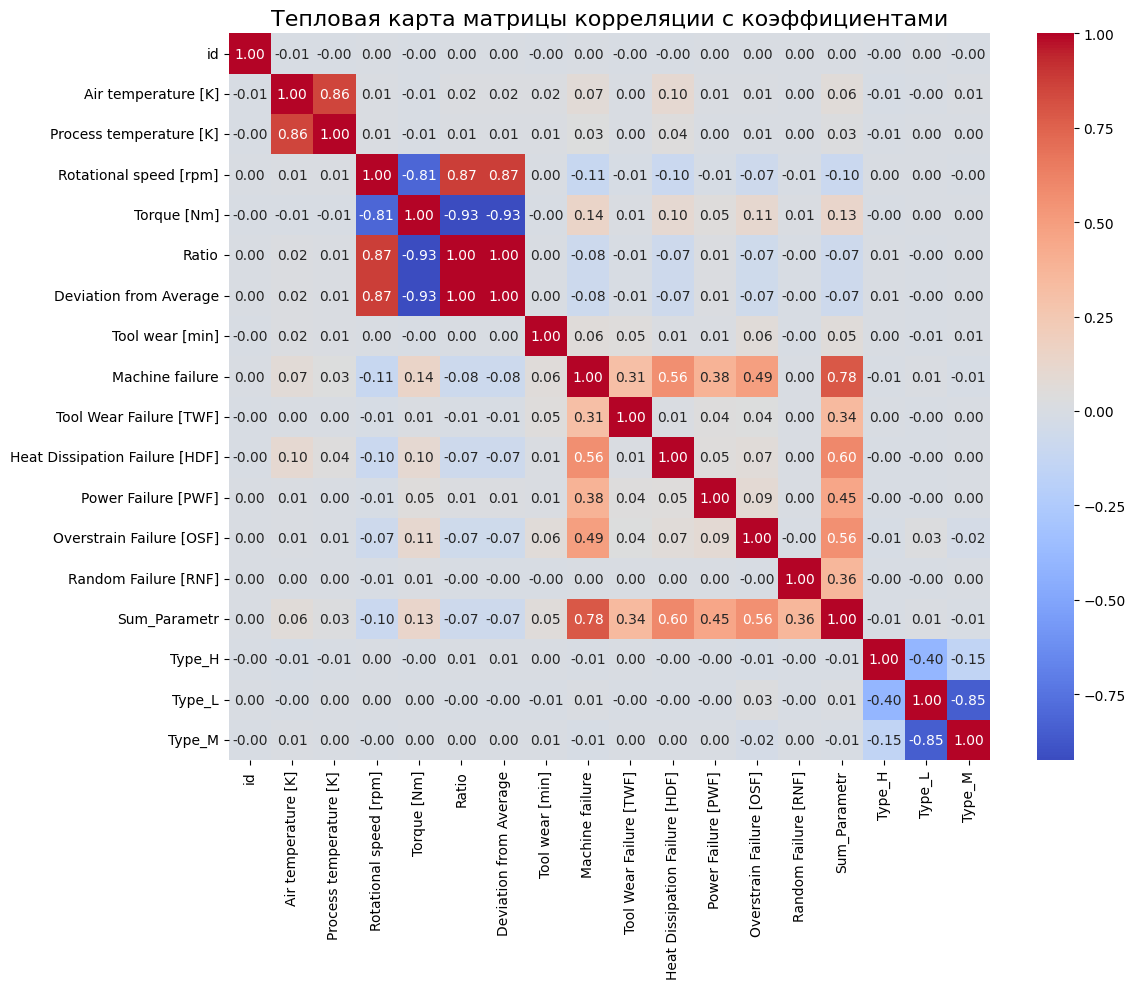

In [19]:
# Расчет корреляционной матрицы
correlation_matrix = data.corr()

# Сохранение корреляционной матрицы в файл
correlation_matrix.to_csv("correlation_matrix.csv")

# Визуализация корреляционной матрицы с аннотацией
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

plt.title("Тепловая карта матрицы корреляции с коэффициентами", fontsize=16)
plt.tight_layout()

# Сохранение тепловой карты с коэффициентами
plt.savefig("correlation_matrix_heatmap_with_values.png")
plt.show()

***Вывод для корреляционной матрицы с точки зрения машинного обучения и анализа признаков (целевая переменная: Machine failure)***

***Целевая переменная: Machine failure***

Целью является предсказание отказов оборудования, и важным шагом является анализ корреляции между этой переменной и другими признаками.

***Признаки с умеренной корреляцией с целевой переменной:***

- `Tool Wear Failure [TWF]` (~0.31):

  Умеренная положительная корреляция с целевой переменной (`Machine failure`) указывает на то, что отказ инструмента (`Tool Wear Failure`) является одной из причин общего отказа оборудования.
  Этот признак потенциально важен для предсказания отказов, так как инструмент, вероятно, изнашивается с течением времени и вызывает поломку.

- `Heat Dissipation Failure [HDF]` (~0.31):

  Умеренная положительная корреляция с целевой переменной. Проблемы с теплоотводом могут способствовать отказам, и данный признак также важен для модели.
  Это указывает на необходимость учета состояния системы охлаждения для предотвращения поломок.

- `Power Failure [PWF]` (~0.38):

  Этот признак имеет умеренную положительную корреляцию с целевой переменной, что свидетельствует о том, что проблемы с подачей электроэнергии играют значительную роль в отказах.
  Следует обратить внимание на наличие источника бесперебойного питания или улучшение стабильности электросети.

- `Overstrain Failure [OSF]` (~0.49):

  Отказ, вызванный перенапряжением, показывает умеренную положительную корреляцию с целевой переменной. Это означает, что оборудование подвержено физическим перегрузкам, которые могут приводить к отказам.
  Этот фактор является важным и должен быть включен в модель для предсказания отказов оборудования.

- `Sum_Parametr` (~0.78):

  Суммарный показатель по отказам имеет наибольшую корреляцию с целевой переменной. Этот признак объединяет все отказы, поэтому его наличие делает модель более информативной.
  Этот признак может использоваться для предсказания общего состояния машины.

***Признаки с низкой корреляцией с целевой переменной:***

- `Rotational speed [rpm]` и `Torque [Nm]`:

  Низкая или почти отсутствующая корреляция с целевой переменной (~0.00). Эти признаки в контексте текущих данных не оказывают значительного влияния на отказ оборудования и, возможно, могут быть исключены из модели для упрощения.

- `Deviation from Average`:

  Имеет низкую корреляцию с целевой переменной (~0.06). Этот показатель отклонения от среднего значения не сильно влияет на возможность отказа оборудования.

- Типы оборудования (`Type_H`, `Type_L`, `Type_M`):

  Все три индикатора имеют почти нулевую корреляцию с целевой переменной. Это указывает на то, что принадлежность оборудования к определенному типу (H, L, M) не оказывает влияния на вероятность отказа. Возможно, эти признаки можно исключить из модели.

***Рекомендации для машинного обучения:***

- **Выбор признаков:**

  - Для построения модели машинного обучения важны признаки с умеренной корреляцией с целевой переменной, такие как `Tool Wear Failure [TWF]`, `Heat Dissipation Failure [HDF]`, `Power Failure [PWF]`, `Overstrain Failure [OSF]` и `Sum_Parametr`.
  - Признаки с низкой корреляцией (`Rotational speed [rpm]`, `Torque [Nm]`, `Deviation from Average` и индикаторы типа оборудования) могут быть исключены, чтобы уменьшить размерность и повысить эффективность модели.

- **Потенциальные улучшения модели:**

  - Включение признаков, связанных с отказами (например, отказ системы охлаждения и перенапряжение), улучшит предсказательную способность модели, так как они имеют значительное влияние на отказ оборудования.
  - Использование `Sum_Parametr`, который отражает общую тенденцию отказов, также полезно для предсказания и раннего обнаружения потенциальных проблем.

- **Подход к моделированию:**

  - Поскольку целевая переменная (`Machine failure`) является бинарной (0 или 1), задачи классификации, такие как логистическая регрессия, деревья решений или случайный лес, могут быть подходящими для построения модели.
  - Использование методов, таких как Random Forest или XGBoost, поможет выявить важные признаки, если их значение не очевидно из анализа корреляции.

- **Контроль за признаками:**

  - Так как износ инструмента и система охлаждения имеют значительное влияние на отказ оборудования, следует наладить систему мониторинга этих параметров для раннего предупреждения отказов.

***Заключение:***

Анализ корреляционной матрицы показал, что наибольшее влияние на отказы оборудования оказывают признаки, связанные с отказами различных систем (`Tool Wear Failure`, `Heat Dissipation Failure`, `Power Failure` и `Overstrain Failure`). Модель машинного обучения для предсказания отказов оборудования должна сосредоточиться на этих признаках, в то время как параметры, не имеющие значительной корреляции, могут быть исключены для упрощения модели и повышения точности.

In [18]:
# Сохранение предобработанных данных
data.to_csv('additional_variable_train.csv', sep=';', index=False) # Обратите внимание на разделитесь!
print("Предобработка завершена. Данные сохранены в 'additional_variable_train.csv'.")
print(data.info())

Предобработка завершена. Данные сохранены в 'additional_variable_train.csv'.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              136429 non-null  int64  
 1   Air temperature [K]             136429 non-null  float64
 2   Process temperature [K]         136429 non-null  float64
 3   Rotational speed [rpm]          136429 non-null  int64  
 4   Torque [Nm]                     136429 non-null  float64
 5   Ratio                           136429 non-null  float64
 6   Deviation from Average          136429 non-null  float64
 7   Tool wear [min]                 136429 non-null  int64  
 8   Machine failure                 136429 non-null  int64  
 9   Tool Wear Failure [TWF]         136429 non-null  int64  
 10  Heat Dissipation Failure [HDF]  136429 non-null  int64  
 11  P